### **Project Showcase - Depression Detection using Twitter Data**

This script contains pre-processing for the twitter data and model creation using PyTorch. 

We used TorchText, a PyTorch libray that made pre-pre-processing both simple and efficient, and applied custom techniques to work with our unique twitter data.

A lot of the preprocessing and model section was inspired by code from this article, as we are new to NLP using PyTorch - https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

In [0]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
import os, sys
import re
import string
import itertools

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Pandas version: 0.24.2
Pytorch version: 1.1.0
Torch Text version: 0.3.1
Spacy version: 2.1.8


## **1. Load Data**

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/tweets_combined.csv")

In [0]:
pd.set_option('display.max_colwidth', -1)

In [12]:
df.head()

,Unnamed: 0,tweet,target
0,0,Wanted to watch the TNF game but I forgot my parents cancelled the NFL Network package ????,0
1,1,For all the years I took the lynx box sets for granted and this year I didn't get one ???¢???‚,0
2,2,"Hon. Miss Dashwood, whose manners very pretty face, she offended you have done before.",0
3,3,ebullient [ih BUL yunt] adj.boiling; bubbling with excitement; exuberant. A boiling liquid can be called ebullient. Excited or enthusiastic.,0
4,4,All the proud parents on fb about their kids school report and am shitting myself for Graces arriving 😂😂😂 #troublemaker,0


In [13]:
df.target.value_counts()

0    1936
1    585 
Name: target, dtype: int64

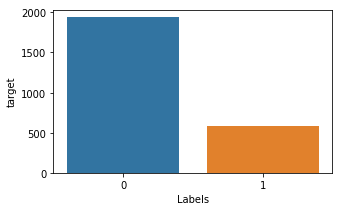

In [14]:
fig = plt.figure(figsize=(5,3))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');

In [15]:
df.tweet.head(10), df.tweet.tail(10)

(0    Wanted to watch the TNF game but I forgot my parents cancelled the NFL Network package ????                                                 
 1    For all the years I took the lynx box sets for granted and this year I didn't get one ???¢???‚                                              
 2    Hon. Miss Dashwood, whose manners very pretty face, she offended you have done before.                                                      
 3    ebullient [ih BUL yunt] adj.boiling; bubbling with excitement; exuberant. A boiling liquid can be called ebullient. Excited or enthusiastic.
 4    All the proud parents on fb about their kids school report and am shitting myself for Graces arriving 😂😂😂  #troublemaker                    
 5    "I  a temporary, contract job but I am hoping for permanent" -  that's heard all too often amongst GenY.                                    
 6    He aint flinch tho, I'll give him that lol                                                                      

In [16]:
# check non-depressive tweets
df[df["target"]==0].tweet.head()

0    Wanted to watch the TNF game but I forgot my parents cancelled the NFL Network package ????                                                 
1    For all the years I took the lynx box sets for granted and this year I didn't get one ???¢???‚                                              
2    Hon. Miss Dashwood, whose manners very pretty face, she offended you have done before.                                                      
3    ebullient [ih BUL yunt] adj.boiling; bubbling with excitement; exuberant. A boiling liquid can be called ebullient. Excited or enthusiastic.
4    All the proud parents on fb about their kids school report and am shitting myself for Graces arriving 😂😂😂  #troublemaker                    
Name: tweet, dtype: object

In [17]:
# check depressive tweets
df[df["target"]==1].tweet.head()

16    It's weird that I get 300x more depressed over Christmas break every year.                                              
20    It's so sad when you talk so highly of someone then they end up disappointing u and making u look like a pendeja        
25    A whopping 9% of adults in America are depressed. Another 3.4% are deeply depressed. Let's Talk!                        
27    Not only have I posted a blog post daily for 2 months I've also filmed and uploaded a daily vlog whilst being severely  
33    HealthTap: I haven't eaten anything all day because I feel  and low What should I do?                                   
Name: tweet, dtype: object

## **2. Define How to Preprocess Data**

In [18]:
# torchtext have trouble handling \n. Replace \n character with space
df['tweet'] = df.tweet.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 2521/2521 [00:00<00:00, 177030.26it/s]


In [0]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [0]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [0]:
def tweet_clean(text):
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove urls
    text = re.sub(r'<([^>]*)>', ' ', text) # remove emojis
    text = re.sub(r'@\w+', ' ', text) # remove at mentions
    text = re.sub(r'#', '', text) # remove hashtag symbol
    text = re.sub(r'[0-9]+', ' ', text) # remove numbers
    text = replace_contractions(text)
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)      
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))    
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    return text.strip()

In [0]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

**Define fields**

In [0]:
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
TARGET = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target =False)

In [0]:
data_fields = [
    (None, None),
    ("tweet", TEXT), 
    ("target", TARGET)
]

## **3. Create Train, Valid and Test datasets**

In [0]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [0]:
# create train and validation set 
train_val, test = split_train_test(df, test_size=0.2)
train, val = split_train_test(train_val, test_size=0.2)

In [0]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [28]:
train.shape, val.shape, test.shape

((1612, 3), (404, 3), (505, 3))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

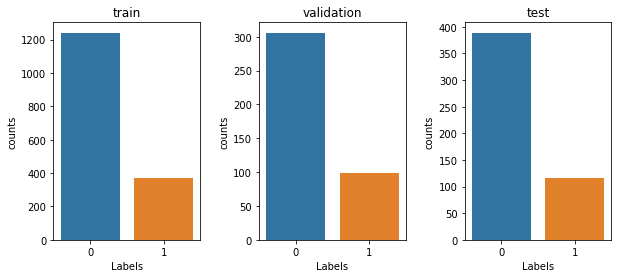

In [29]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [30]:
%%time
train_data, val_data, test_data = TabularDataset.splits(path='./', format='csv', train='train.csv', validation='val.csv', test='test.csv', fields=data_fields, skip_header=True)

CPU times: user 1.75 s, sys: 52 ms, total: 1.8 s
Wall time: 1.76 s


In [31]:
len(train_data), len(val_data), len(test_data)

(1612, 404, 505)

## **4. Load pretrained embeddings and build vocab**

In [32]:
!ls '/content/gdrive/My Drive/embedding'

glove.6B.100d.txt  glove.twitter.27B.100d.txt	  uncased_L-12_H-768_A-12.zip
glove.6B.200d.txt  glove.twitter.27B.100d.txt.pt


In [33]:
%%time
vec = torchtext.vocab.Vectors('glove.twitter.27B.100d.txt', '/content/gdrive/My Drive/embedding')

CPU times: user 532 ms, sys: 644 ms, total: 1.18 s
Wall time: 1.45 s


In [34]:
len(train_data)

1612

In [35]:
%%time
MAX_VOCAB_SIZE = 100_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors=vec)

TARGET.build_vocab(train_data)

CPU times: user 98.7 ms, sys: 2.02 ms, total: 101 ms
Wall time: 106 ms


In [36]:
TEXT.vocab.vectors.shape

torch.Size([4577, 100])

In [37]:
train_data

## **5. Load data in batches**

We will use the BucketIterator to access the Dataloader. It sorts data according to length of text, and groups similar length text in a batch, thus reducing the amount of padding required. It pads the batch according to the max length in that particular batch

In [0]:

train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(3,3,3), 
                                            sort_key=lambda x: len(x.tweet), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [39]:
len(train_loader), len(val_loader), len(test_loader)

(538, 135, 169)

In [40]:
batch = next(iter(train_loader))
type(batch)

torchtext.data.batch.Batch

In [41]:
batch.target

tensor([0, 0, 0])

In [42]:
batch.tweet

(tensor([[  28, 1512,  113],
         [ 143,  118,  682],
         [ 392,  670,  838],
         [1771,    5,   13],
         [  14, 1414,   57],
         [1137, 1258,  160]]), tensor([6, 6, 6]))

In [43]:
TEXT.vocab.itos[1]

'<pad>'

In [0]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.tweet[0][:,idx].cpu().data.numpy()])

In [45]:
idxtosent(batch,0)

'do nt worry abt it bb'

In [46]:
batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x7f6534bbfa90>,
 'fields': dict_keys([None, 'tweet', 'target']),
 'input_fields': ['tweet', 'target'],
 'target': tensor([0, 0, 0]),
 'target_fields': [],
 'tweet': (tensor([[  28, 1512,  113],
          [ 143,  118,  682],
          [ 392,  670,  838],
          [1771,    5,   13],
          [  14, 1414,   57],
          [1137, 1258,  160]]), tensor([6, 6, 6]))}

In [0]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [48]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
next(iter(train_batch_it))

((tensor([[ 227,    3,  665],
          [2795,   64, 1387],
          [4003,    3, 1181],
          [  94, 1038, 1760],
          [3846,   42, 1095],
          [   4,    7, 1179],
          [3867,  554,   30],
          [ 430, 3337,  230],
          [   4,    2, 1316],
          [1140,   37,    2],
          [   6,    3,    8],
          [1752,   35,  401],
          [  16,   28, 1433],
          [ 267,   15,   29],
          [2268,   64,   20],
          [3689,    3,  404],
          [ 169,   23,  665],
          [ 385, 3854,    2],
          [   9,    4,  168],
          [1368,  222,   49],
          [ 727,  964, 1305],
          [ 720,    2,    2]]), tensor([22, 22, 22])), tensor([0, 1, 0]))

## **6. Models and Training**

For the model, we decided to follow the example in https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8, but make small modifications such as adding some dropout, to prevent overfitting

The model is uses a pre-trained embedding layer from glove, a bidirectional GRU and also a concat pooling method where we perform average pool and max pool and then concatenate the results.

The final result was ok, with around 80% test accuracy. It was clear that the model was overfitting but we had run out of time to make further adjustments. This has been a very educational experience as it was our first time implementing NLP using PyTorch. We plan to experiment and improve the model using a varitey of methods in the future.

In [0]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
n_hidden = 64
n_out = 2

In [0]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.fc = nn.Linear(self.n_hidden*2, self.n_out)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1) 
        
        cat = self.dropout(torch.cat([avg_pool,max_pool],dim=1))
        
        outp = self.fc(cat)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [0]:
def train(model, iterator, optimizer, criterion, num_batch):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
  
        #t = tqdm_notebook(iterator, leave=False, total=num_batch)
    
        for (X,lengths),y in iterator:

          #t.set_description(f'Epoch {epoch}')
          lengths = lengths.cpu().numpy()

          opt.zero_grad()
          pred = model(X, lengths)
          loss = criterion(pred, y)
          loss.backward()
          opt.step()

          #t.set_postfix(loss=loss.item())
          pred_idx = torch.max(pred, dim=1)[1]

          y_true_train += list(y.cpu().data.numpy())
          y_pred_train += list(pred_idx.cpu().data.numpy())
          total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/num_batch
        return train_loss, train_acc

In [0]:
def evaluate(model, iterator, criterion, num_batch):
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in iterator: #tqdm_notebook(iterator, leave=False): 
            
              pred = model(X, lengths.cpu().numpy())
              loss = criterion(pred, y)
              pred_idx = torch.max(pred, 1)[1]
              y_true_val += list(y.cpu().data.numpy())
              y_pred_val += list(pred_idx.cpu().data.numpy())
              total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/num_batch
            return valloss, valacc
         

In [0]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(32,32,32), 
                                            sort_key=lambda x: len(x.tweet), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [0]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
val_batch_it = BatchGenerator(val_loader, 'tweet', 'target')
test_batch_it = BatchGenerator(test_loader, 'tweet', 'target')

In [0]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['tweet'].vocab.vectors, 0.5).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)


In [0]:
loss_fn=F.nll_loss
epochs=10

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
best_valid_loss = float('inf')

epochs=10

for epoch in range(epochs):      

    start_time = time.time()
    
    train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
    valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), 'tut4-model.pt')
          
        
    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f}')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: train_loss: 0.5438 train_acc: 0.7599 | val_loss: 0.5334 val_acc: 0.7574
Epoch 1: train_loss: 0.4733 train_acc: 0.7829 | val_loss: 0.4746 val_acc: 0.7797
Epoch 2: train_loss: 0.4218 train_acc: 0.8015 | val_loss: 0.4234 val_acc: 0.8020
Epoch 3: train_loss: 0.3920 train_acc: 0.8139 | val_loss: 0.4133 val_acc: 0.8045
Epoch 4: train_loss: 0.3640 train_acc: 0.8319 | val_loss: 0.4217 val_acc: 0.7921
Epoch 5: train_loss: 0.3424 train_acc: 0.8406 | val_loss: 0.3862 val_acc: 0.8342
Epoch 6: train_loss: 0.3226 train_acc: 0.8474 | val_loss: 0.4097 val_acc: 0.8045
Epoch 7: train_loss: 0.3181 train_acc: 0.8524 | val_loss: 0.4272 val_acc: 0.7970
Epoch 8: train_loss: 0.2910 train_acc: 0.8716 | val_loss: 0.3975 val_acc: 0.8094
Epoch 9: train_loss: 0.2587 train_acc: 0.8877 | val_loss: 0.4128 val_acc: 0.8069


In [59]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.409 | Test Acc: 80.59%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
